In [56]:
#MODULES
import pandas as pd
from datetime import datetime,timedelta
import holidays
# Detect US holidays
#hldys = holidays.country_holidays('US')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

import numpy as np
pd.set_option('display.max_columns', None)


This dataset provides daily stock prices and volume of Apple. 
Here are columns description:
| Column    | Description                                                      |
|-----------|------------------------------------------------------------------|
| Date      | Date of trading day                                              |
| Open      | Stock price at market open                                       |
| High      | Highest stock price during the trading day                       |
| Low       | Lowest stock price during the trading day                        |
| Close     | Stock price at market close                                      |
| Adj Close | Adjusted closing price accounting for dividends and stock splits |
| Volume    | Number of shares traded.                                         |

In [57]:
input_data = pd.read_csv("./data/AppleStockPrice.csv")#csv taken from -> https://www.kaggle.com/datasets/muhammadbilalhaneef/-apple-stock-prices-from-1981-to-2023
#input_data.columns = input_data.columns.str.lower()
input_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,12-12-1980,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1,15-12-1980,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
2,16-12-1980,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
3,17-12-1980,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
4,18-12-1980,0.118862,0.119420,0.118862,0.118862,0.091630,73449600
...,...,...,...,...,...,...,...
11030,16-09-2024,216.540000,217.220000,213.920000,216.320000,216.320000,59357400
11031,17-09-2024,215.750000,216.900000,214.500000,216.790000,216.790000,45519300
11032,18-09-2024,217.550000,222.710000,217.540000,220.690000,220.690000,59894900
11033,19-09-2024,224.990000,229.820000,224.630000,228.870000,228.870000,66781300


In [58]:
input_data = pd.read_csv("./data/AppleStockPrice.csv")#csv taken from -> https://www.kaggle.com/datasets/muhammadbilalhaneef/-apple-stock-prices-from-1981-to-2023
input_data.columns = input_data.columns.str.strip().str.lower().str.replace(" ","_")
input_data['date'] = pd.to_datetime(input_data['date'],format='%d-%m-%Y')
input_data.set_index('date',inplace=True)
input_data.sort_index(inplace=True)
print("\n NA's\n",input_data.isna().sum())#checking for NA's
print("\n Dtypes--->\n",input_data.dtypes)#seems ok
print("\n duplicates:\n",sum(input_data.duplicated()))


 NA's
 open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

 Dtypes--->
 open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object

 duplicates:
 0


In [59]:
input_data

,open,high,low,close,adj_close,volume
date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600
...,...,...,...,...,...,...
2024-09-16,216.540000,217.220000,213.920000,216.320000,216.320000,59357400
2024-09-17,215.750000,216.900000,214.500000,216.790000,216.790000,45519300
2024-09-18,217.550000,222.710000,217.540000,220.690000,220.690000,59894900


In [60]:
#cutting on dates: 2015-2024
input_data = input_data[
            (input_data.index>=pd.to_datetime('2015-01-01')) 
            &
            (input_data.index<=pd.to_datetime('2024-01-01'))
           ]

In [61]:
us_public_holidays = pd.Series(holidays.country_holidays('US',  years = range(
                                                             input_data.index.min().year,
                                                             input_data.index.max().year+1
                                                            )
                                         )
               )
us_public_holidays = pd.DataFrame(us_public_holidays).reset_index().rename(columns={'index':'Date',0:'holiday_name'}).set_index('Date').sort_index()
us_public_holidays

,holiday_name
Date,
2015-01-01,New Year's Day
2015-01-19,Martin Luther King Jr. Day
2015-02-16,Washington's Birthday
2015-05-25,Memorial Day
2015-07-03,Independence Day (observed)
...,...
2023-10-09,Columbus Day
2023-11-10,Veterans Day (observed)
2023-11-11,Veterans Day


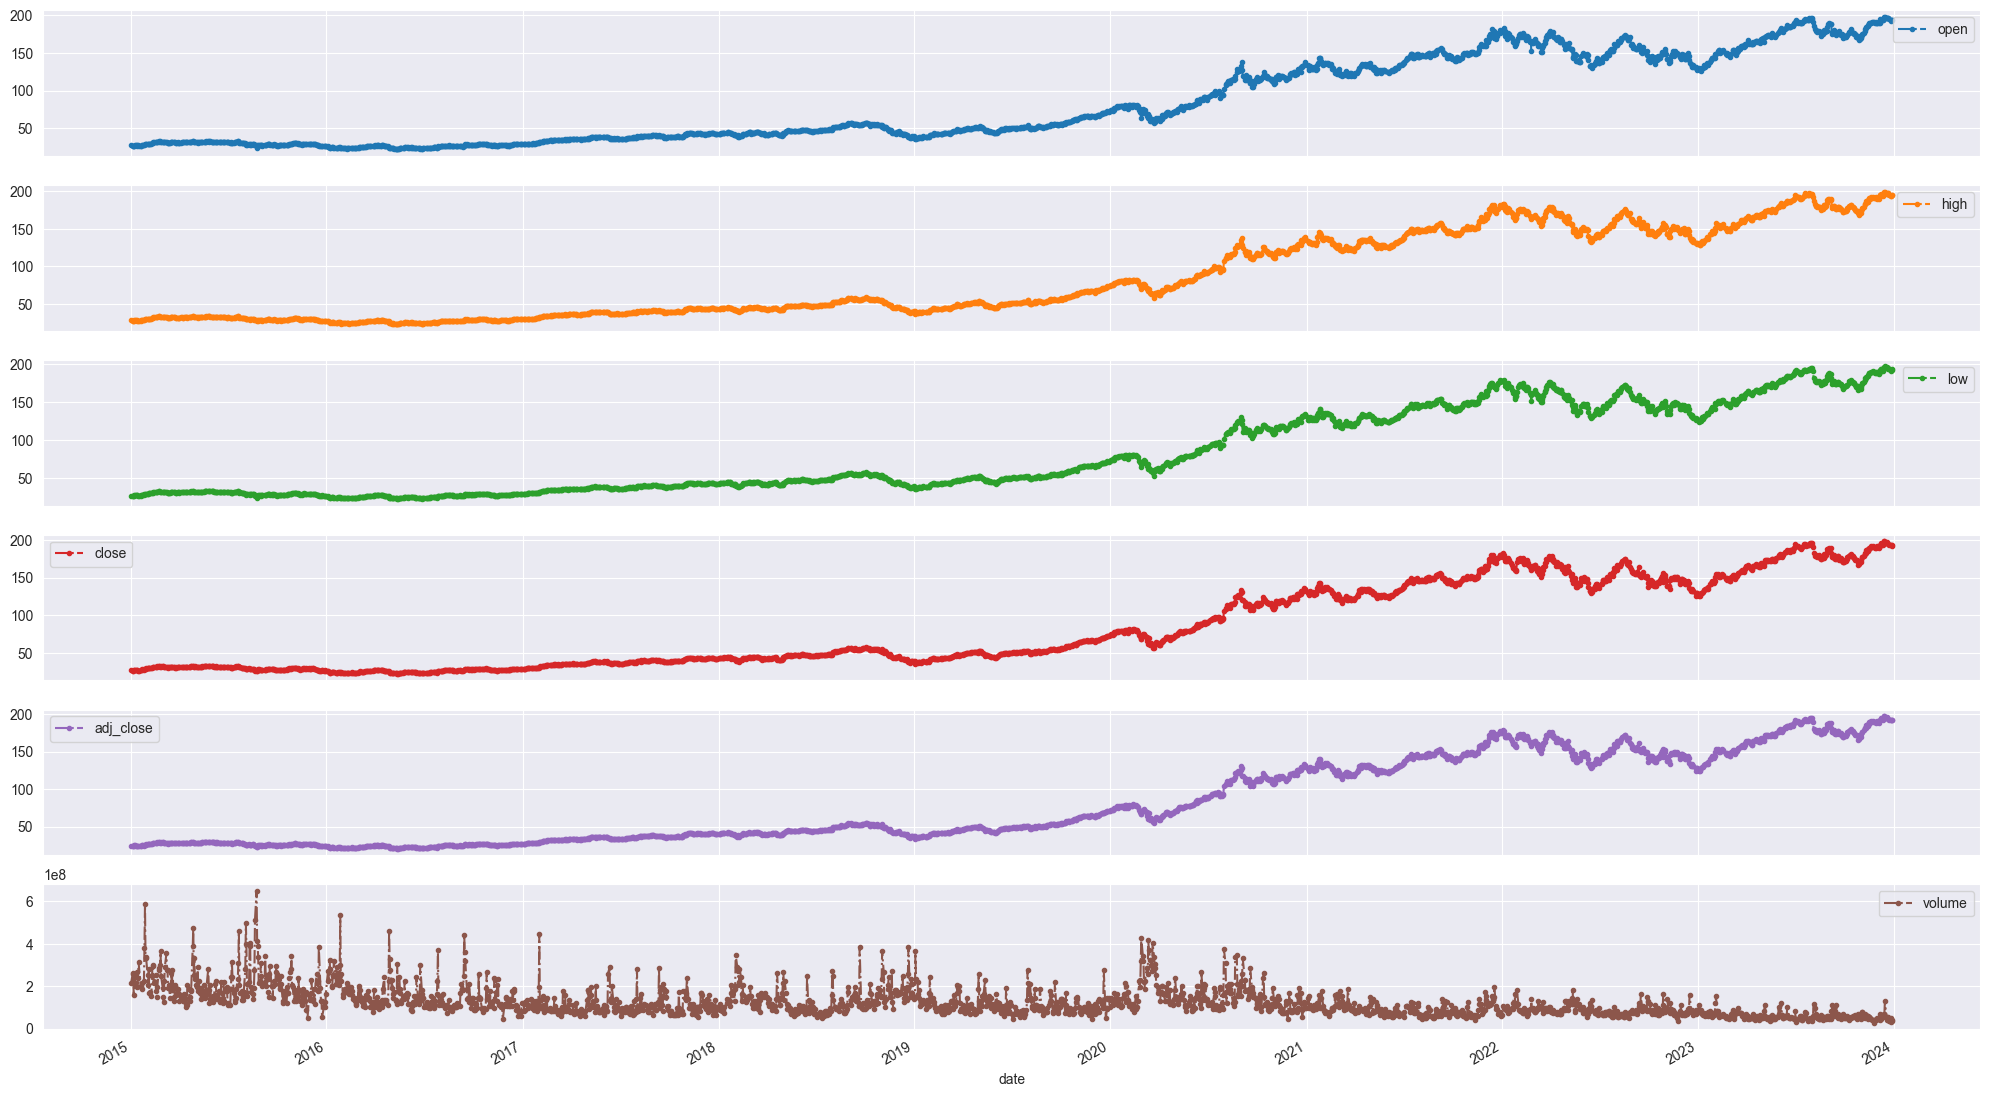

In [62]:
input_data.plot(figsize=(25,15),marker='.',linestyle='-.',subplots=True);

In [63]:
#By resampling we can locate the missing dates
#we flag them weekend OR US holiday
input_data_nan = input_data.resample('D').asfreq()
input_data_nan = input_data_nan.join(us_public_holidays)#adding holidays
input_data_nan['day_name'] = pd.to_datetime(input_data_nan.index).day_name();#adding nameday
input_data_nan['holiday_name'] = input_data_nan.apply(lambda row: 'weekend' if (row.day_name in ['Saturday','Sunday'] and pd.isnull(row.holiday_name)) else row.holiday_name, axis=1)#weekend flag only if there is no holiday_name already filled
input_data_nan = input_data_nan[input_data_nan[input_data_nan.columns[0]].isna()]#select Missing rows (by chosing the first column randomly "0")
input_data_nan

,open,high,low,close,adj_close,volume,holiday_name,day_name
date,,,,,,,,
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Sunday
2015-01-10,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
2015-01-11,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Sunday
2015-01-17,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
...,...,...,...,...,...,...,...,...
2023-12-16,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
2023-12-17,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Sunday
2023-12-23,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday


In [64]:
#distribution of US holidays along the week days
pd.DataFrame(input_data_nan.groupby(['day_name','holiday_name']).size()).rename(columns={0:'counts'}).sort_index()

counts
day_name  holiday_name                                           
Friday    Christmas Day                                         2
          Christmas Day (observed)                              1
          Independence Day (observed)                           2
          New Year's Day                                        2
Monday    Christmas Day                                         2
          Christmas Day (observed)                              2
          Independence Day                                      2
          Independence Day (observed)                           1
          Juneteenth National Independence Day                  1
          Juneteenth National Independence Day (observed)       1
          Labor Day                                             9
          Martin Luther King Jr. Day                            9
          Memorial Day                                          9
          New Year's Day                                        1
          New Year's Day (observed)                             2
          Washington's Birthday                                 9
Saturday  Christmas Day                                         1
          Independence Day                                      2
          Juneteenth National Independence Day                  1
          New Year's Day                                        1
          Veterans Day                                          2
          weekend                                             462
Sunday    Christmas Day                                         2
          Independence Day                                      1
          Juneteenth National Independence Day                  1
          New Year's Day                                        2
          Veterans Day                                          1
          weekend                                             462
Thursday  Independence Day                                      1
          Thanksgiving                                          9
Tuesday   Christmas Day                                         1
          Independence Day                                      2
          New Year's Day                                        1
Wednesday Christmas Day                                         1
          Independence Day                                      1
          New Year's Day                                        1

In [65]:
#check for missing consecutive dates 
df = input_data_nan.reset_index()[['date']]
#df = input_data_nan['Date']
df.sort_values('date',inplace=True)
df['time_diff'] = df['date'].diff()
one_day = timedelta(days=1) 
df['group'] = (df['time_diff'] > one_day).cumsum()#differentiate the group that consecutive days belong to
df

,date,time_diff,group
0,2015-01-03,NaT,0
1,2015-01-04,1 days,0
2,2015-01-10,6 days,1
3,2015-01-11,1 days,1
4,2015-01-17,6 days,2
...,...,...,...
1015,2023-12-16,6 days,485
1016,2023-12-17,1 days,485
1017,2023-12-23,6 days,486
1018,2023-12-24,1 days,486


(1.0, 1000.0)

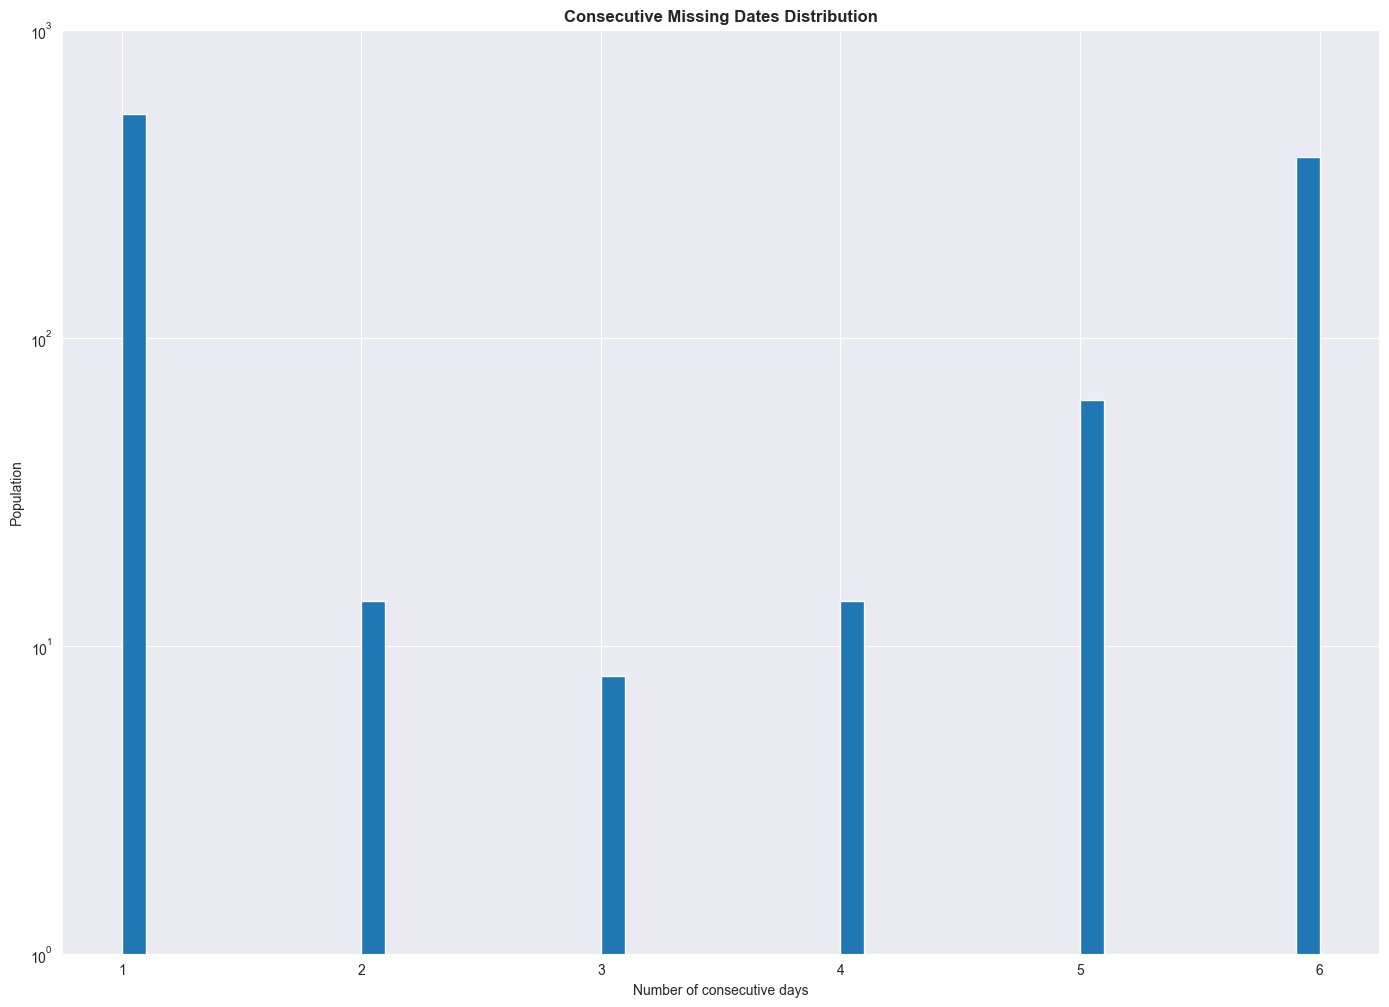

In [66]:
(df['time_diff'].dt.total_seconds()/(3600*24)).hist(bins=50,log=True,figsize=(17,12))
plt.xlabel('Number of consecutive days')
plt.ylabel('Population')
plt.title('Consecutive Missing Dates Distribution',fontweight = "bold")
plt.ylim(1e+0,1e+3)

# There exist two ways of treating _missing values_
## Create the dates and interpolate them OR 
## Ignore them and work only with trading days

In [67]:
#Calculate Daily Returns based on input_data['daily_return'] = (input_data[selected_column]- input_data[selected_column].shift(-1))/input_data[selected_column].shift(-1) <=> pd.pct(periods=-1) <- CHECKED!
input_data.loc[:,'daily_return'] = input_data['adj_close'].pct_change(periods=-1)
input_data.dropna(inplace=True)
display(input_data)

C:\Users\agero\AppData\Local\Temp\ipykernel_24424\1016282578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:,'daily_return'] = input_data['adj_close'].pct_change(periods=-1)
C:\Users\agero\AppData\Local\Temp\ipykernel_24424\1016282578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.dropna(inplace=True)


,open,high,low,close,adj_close,volume,daily_return
date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373957,212818400,0.028988
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000,-0.000094
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689531,263188400,-0.013829
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021717,160423600,-0.037000
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000,-0.001071
...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,193.944031,46482500,0.005578
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800,0.002849
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,-0.000518


C:\Users\agero\AppData\Local\Temp\ipykernel_24424\831796126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:,'extreme_event'] = np.where(np.abs(input_data['daily_return'])>margin,1,0) #(np.abs(input_data['daily_return']>margin)).astype(int)####BUG Is THE minus reflected on the extreme_event


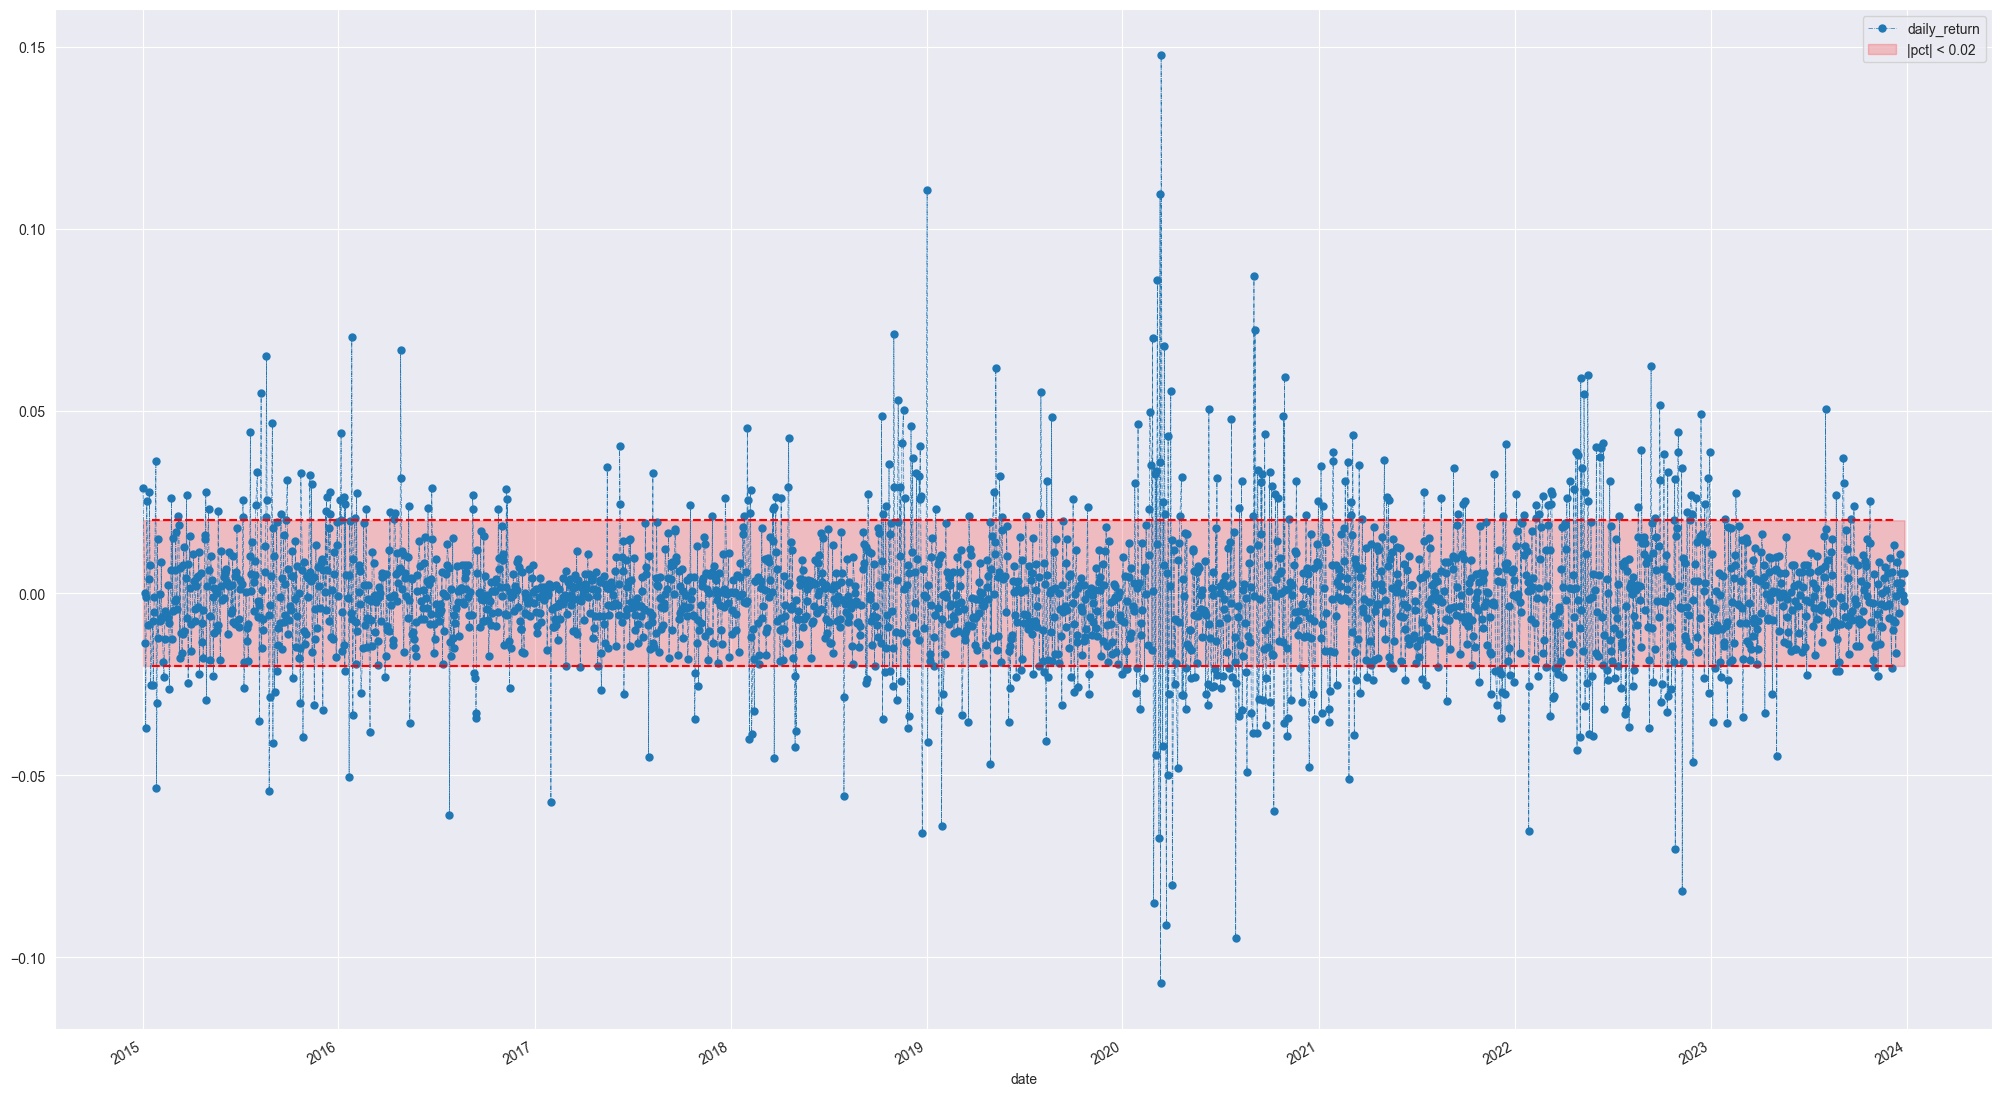

In [68]:
margin = 0.02#  np.where(df['value'].abs() > 0.02, 1, 0)
input_data.loc[:,'extreme_event'] = np.where(np.abs(input_data['daily_return'])>margin,1,0) #(np.abs(input_data['daily_return']>margin)).astype(int)####BUG Is THE minus reflected on the extreme_event
input_data.plot(y='daily_return',marker='.',linestyle='-.',linewidth=.5,ms=10,figsize=(25,15))
plt.axhline(xmin=0.05,xmax=.95,y=margin, color='red', linestyle='--')
plt.axhline(xmin=0.05,xmax=.95,y=-margin, color='red', linestyle='--')
plt.fill_between(x=input_data.index,y1=margin,y2=-margin,color='red',alpha=0.2,label=f'|pct| < {margin}')
plt.legend()

In [69]:
#check the distributions based on extreme event flag
input_data.groupby('extreme_event').size()

extreme_event
0    1807
1     456
dtype: int64

array([[<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'high'}>,
        <Axes: title={'center': 'low'}>],
       [<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'adj_close'}>,
        <Axes: title={'center': 'volume'}>],
       [<Axes: title={'center': 'daily_return'}>,
        <Axes: title={'center': 'extreme_event'}>, <Axes: >]],
      dtype=object)

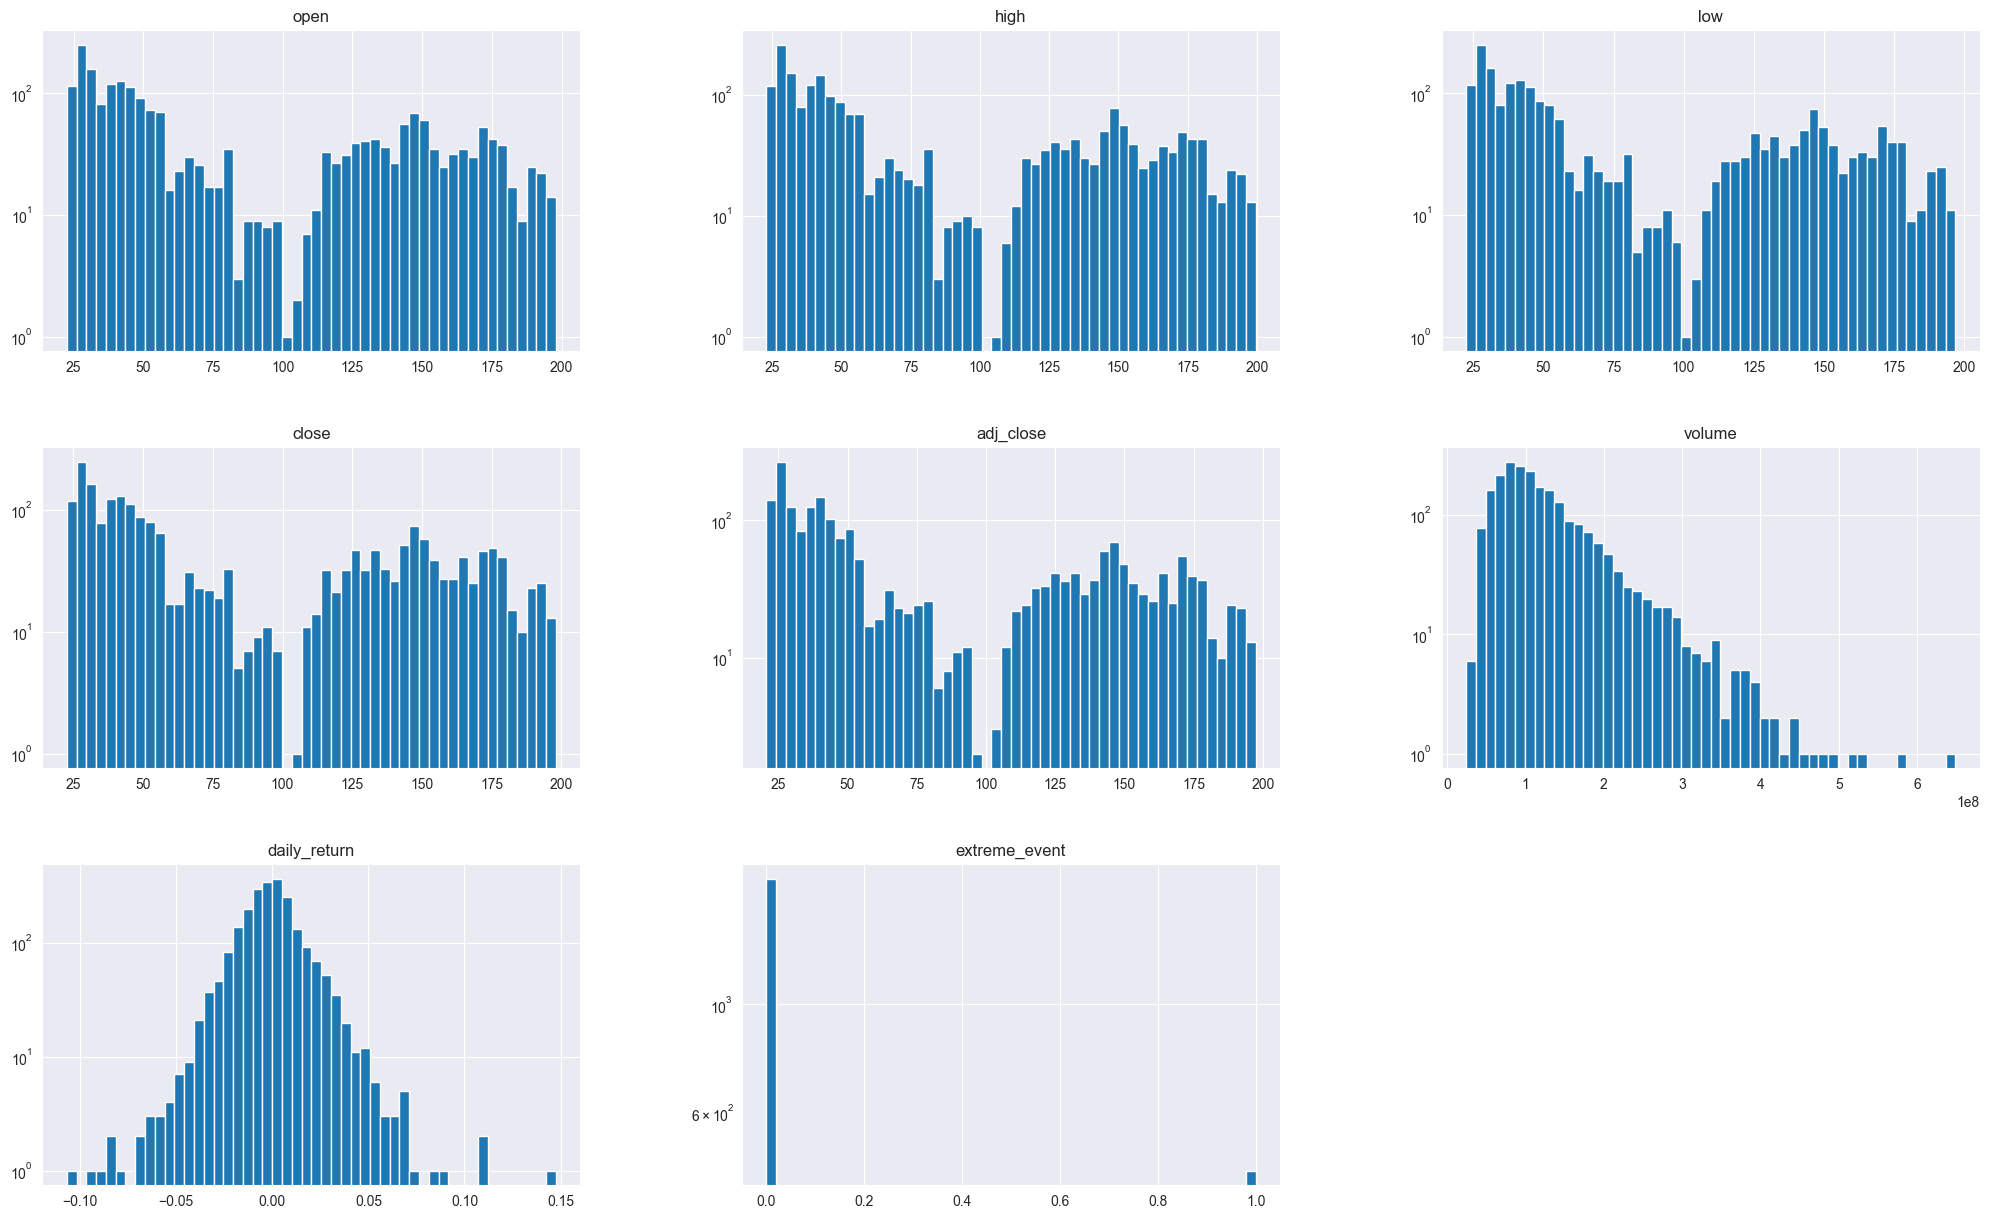

In [70]:
input_data.hist(figsize=(25,15),bins=50,log=True)

extreme_event
0    [[Axes(0.125,0.666111;0.215278x0.213889), Axes(0.404861,0.666111;0.215278x0.213889), Axes(0.684722,0.666111;0.215278x0.213889)], [Axes(0.125,0.388056;0.215278x0.213889), Axes(0.404861,0.388056;0.215278x0.213889), Axes(0.684722,0.388056;0.215278x0.213889)], [Axes(0.125,0.11;0.215278x0.213889), Axes(0.404861,0.11;0.215278x0.213889), Axes(0.684722,0.11;0.215278x0.213889)]]
1    [[Axes(0.125,0.666111;0.215278x0.213889), Axes(0.404861,0.666111;0.215278x0.213889), Axes(0.684722,0.666111;0.215278x0.213889)], [Axes(0.125,0.388056;0.215278x0.213889), Axes(0.404861,0.388056;0.215278x0.213889), Axes(0.684722,0.388056;0.215278x0.213889)], [Axes(0.125,0.11;0.215278x0.213889), Axes(0.404861,0.11;0.215278x0.213889), Axes(0.684722,0.11;0.215278x0.213889)]]
dtype: object

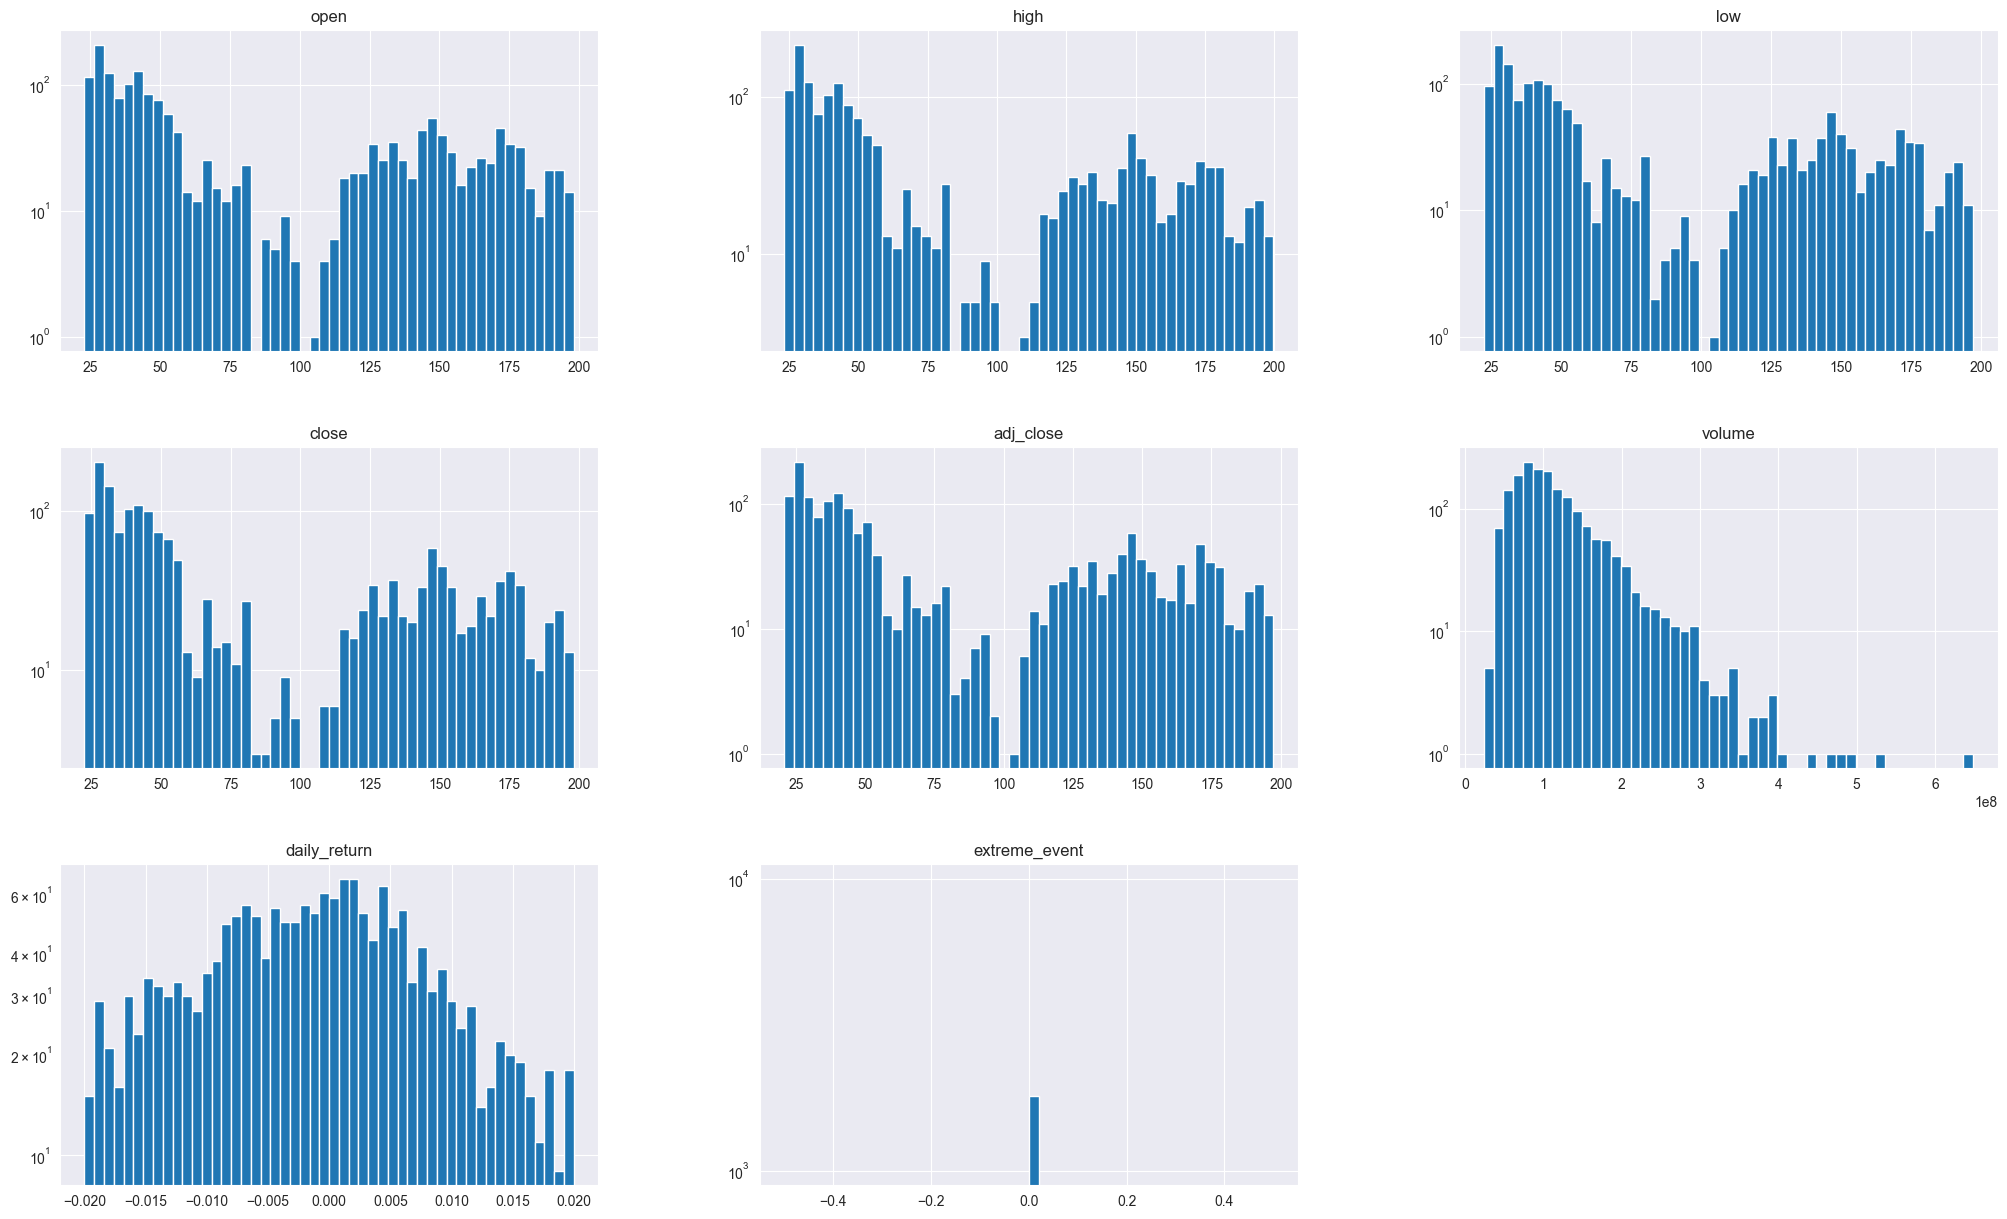

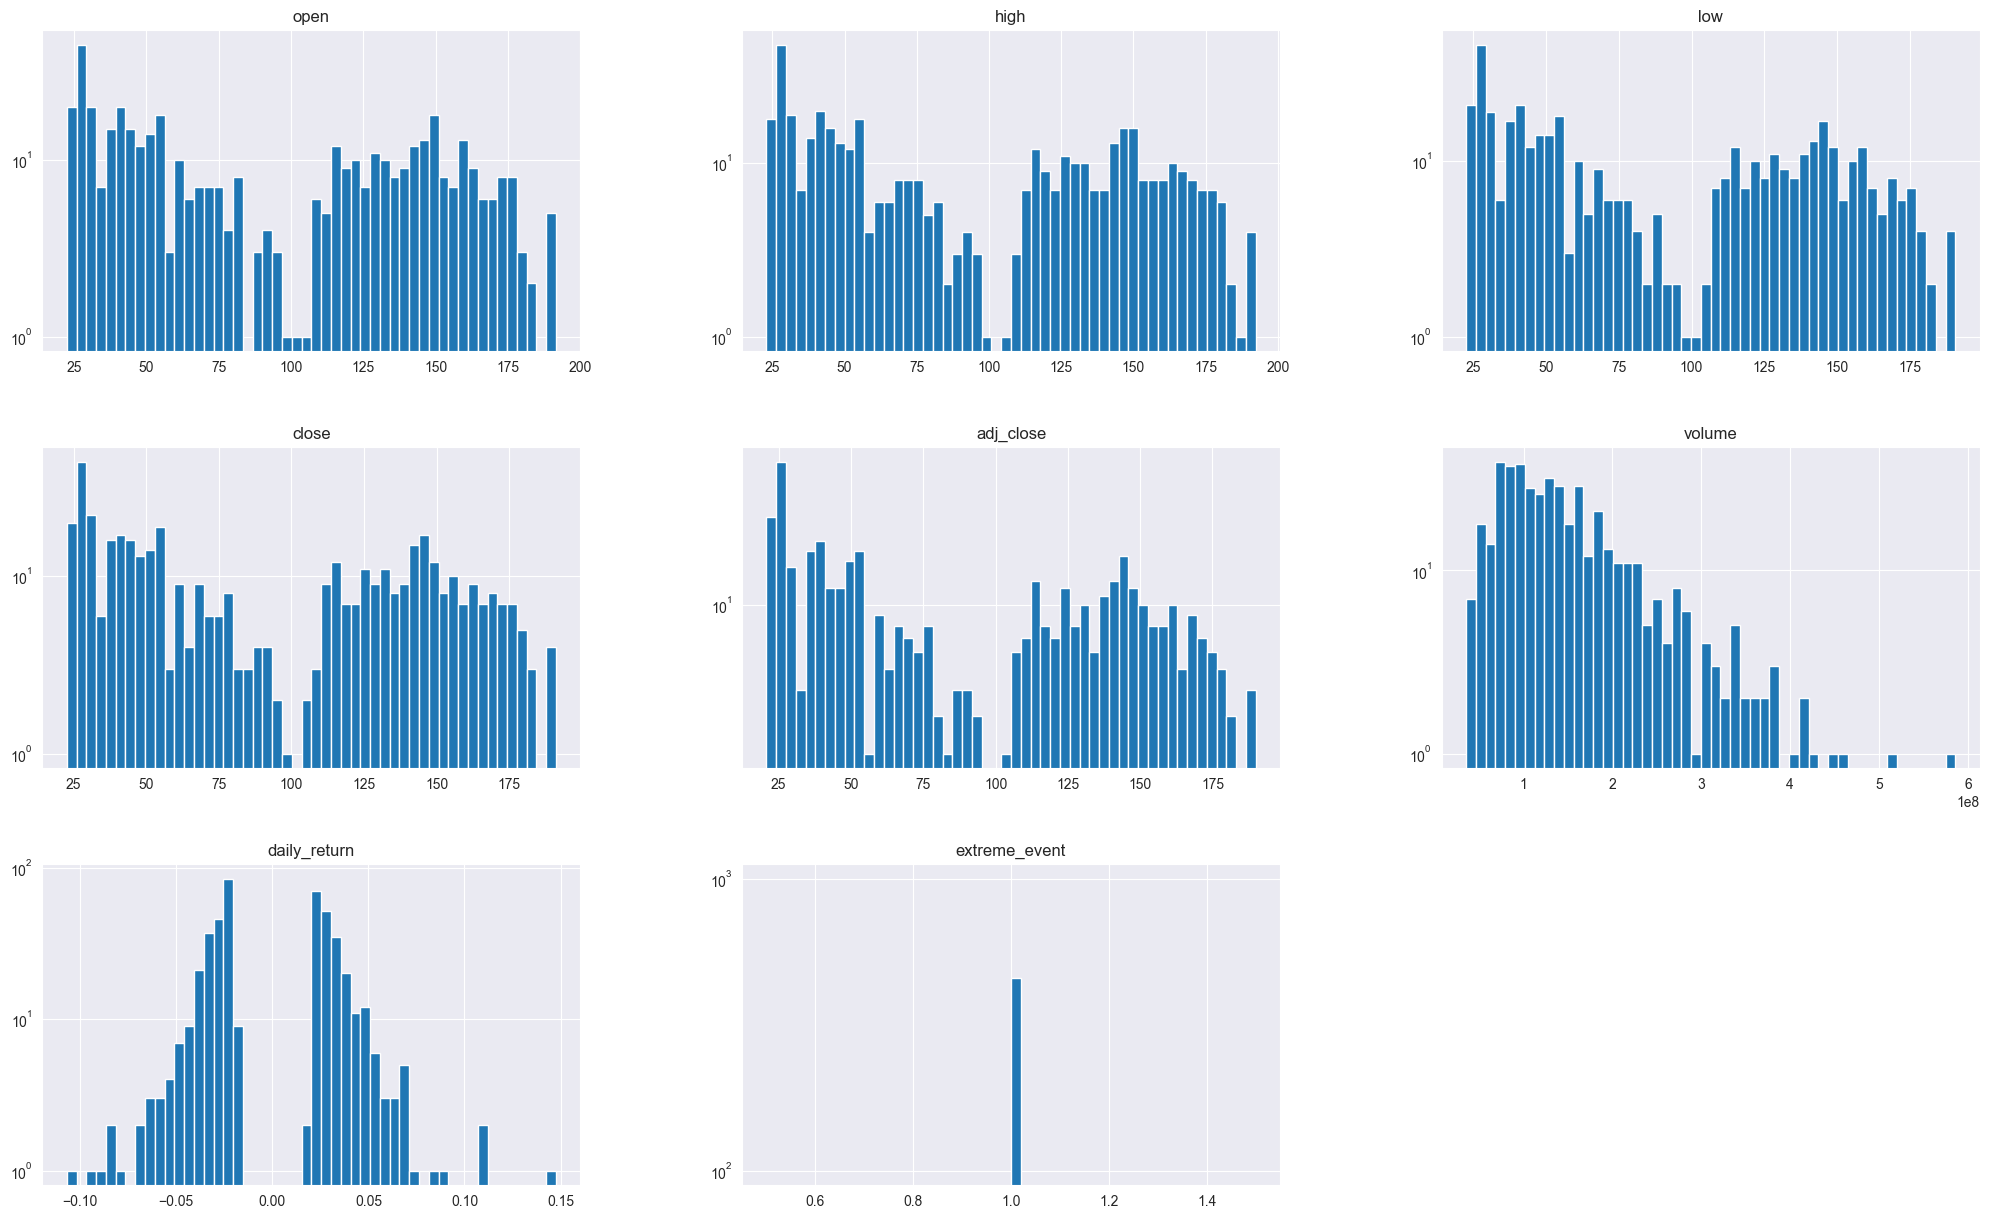

In [71]:
#All hists based on extreme or not event
input_data.groupby('extreme_event').hist(figsize=(25,15),bins=50,log=True)

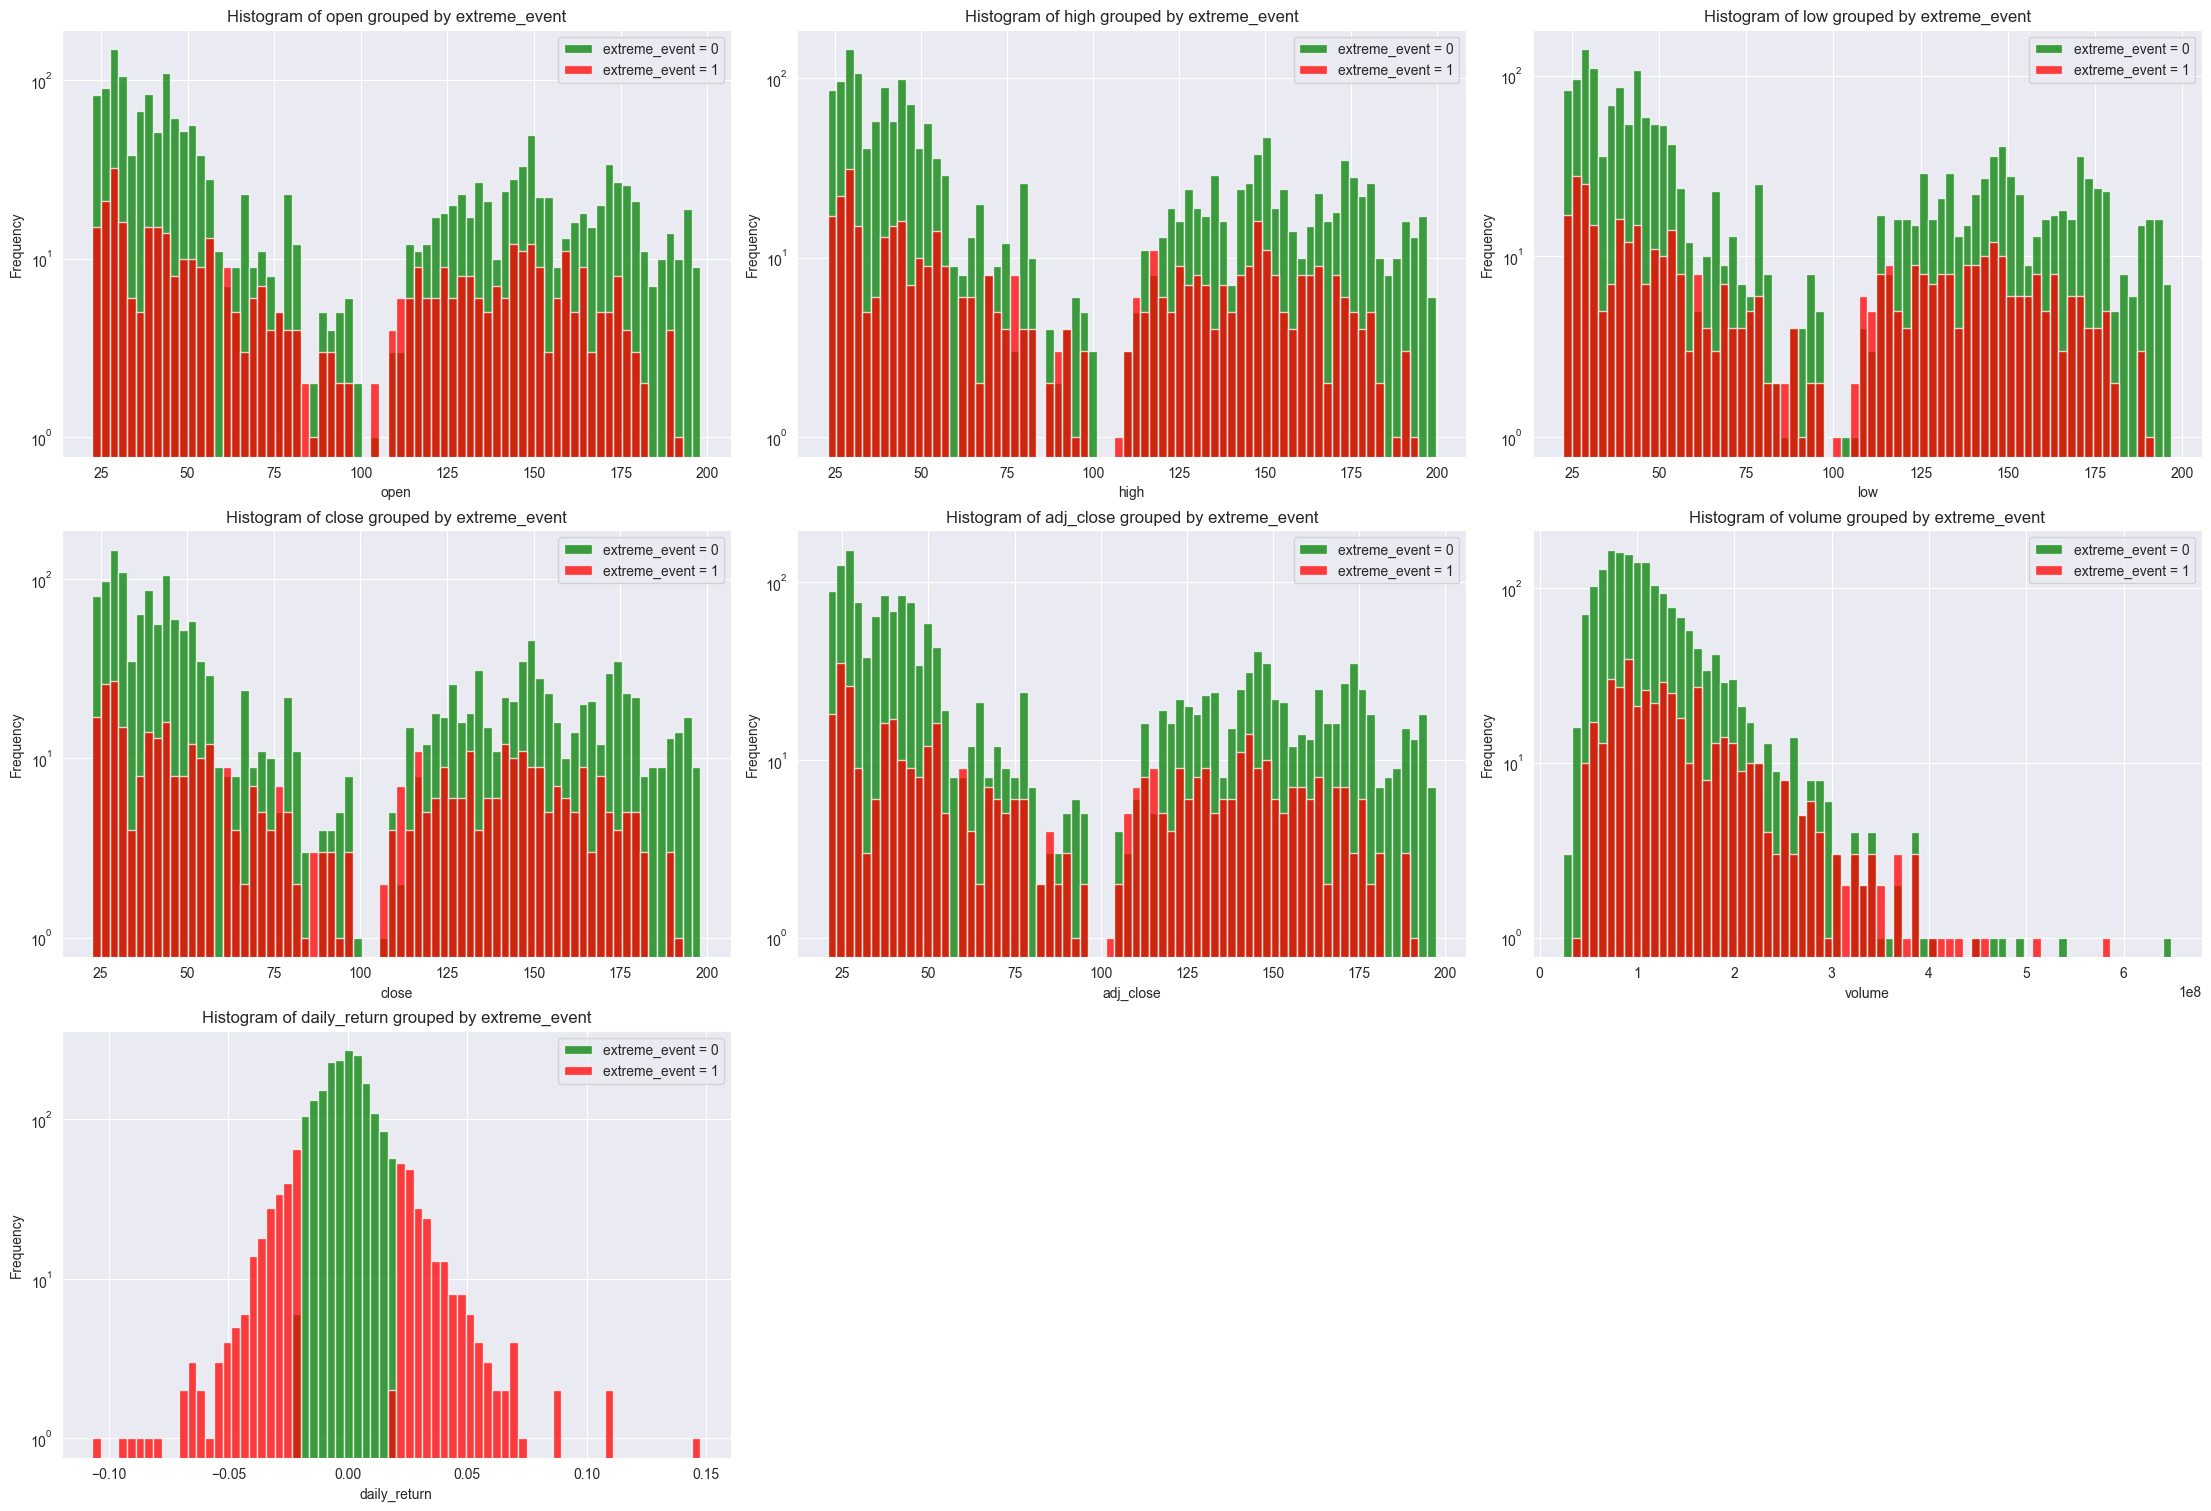

In [72]:
df = input_data

# Define the grouping column and color dictionary
group_column = 'extreme_event'
color_dict = {0: 'green', 1: 'red'}  # Adjust keys to match actual unique values in extreme_event

n_cols = 3  # Number of columns in the grid layout
n_rows = (len(df.columns) - 1) // n_cols + 1  # Calculate rows needed, excluding 'extreme_event'

# Set up the figure and axes for the grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 5 * n_rows), constrained_layout=True)

# Flatten axes to make it easier to iterate, even for single rows/columns
axes = axes.flatten()

# Loop through each column except the grouping column
for i, plot_column in enumerate([col for col in df.columns if col != group_column]):
    
    # Calculate the global min and max for each plot_column
    global_min = df[plot_column].min()
    global_max = df[plot_column].max()
    num_bins = 70  # Set the desired number of bins
    
    # Define global bin edges across the column's min and max range
    bin_edges = np.linspace(global_min, global_max, num_bins + 1)
    
    # Loop through each group in the grouping column to plot on the same subplot
    for name, group in df.groupby(group_column):
        custom_color = color_dict.get(name, 'blue')  # Use color from dictionary, default to 'blue' if not found
        axes[i].hist(group[plot_column], bins=bin_edges, alpha=0.75, label=f'{group_column} = {name}', log = True, color=custom_color)
    
    # Set labels, title, and legend for each subplot
    axes[i].set_xlabel(plot_column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {plot_column} grouped by {group_column}')
    axes[i].legend()

# Hide any empty subplots if there are extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()


In [73]:
#keep the x_i's and Y that will be used for modelling
#For time-series data, ensure the model is only trained on past data and tested on future data, preserving temporal order.
final_input_data = input_data[[col for col in input_data.columns if col != 'Adj Close']]
final_input_data

,open,high,low,close,adj_close,volume,daily_return,extreme_event
date,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373957,212818400,0.028988,1
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000,-0.000094,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689531,263188400,-0.013829,0
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021717,160423600,-0.037000,1
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000,-0.001071,0
...,...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,193.944031,46482500,0.005578,0
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800,0.002849,0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,-0.000518,0


In [74]:
#To predict a binary outcome (y = 0 or 1) using the past 10 days of historical data, 
# we can structure your data such that each row contains the historical data for the past 10 days, 
# and the target variable y is the value for the prediction (either 0 or 1).
# Use the values from the previous 10 days as features (X).
# Create an empty list to store all lag features
lag_features  = []
window_size   = 10
target_column = 'extreme_event'
df = final_input_data.copy()
# Loop through each column and create the lag features
for i in range(1, window_size + 1):
    for col in df.columns:
        if col != target_column:  #Skip the target variable
            if i<10:
                lag_features.append(df[col].shift(i).rename(f'{col}_lag0{i}'))
            else:
                lag_features.append(df[col].shift(i).rename(f'{col}_lag{i}'))

# Concatenate all lag features as new columns to the original dataframe
final_input_data_lagged = pd.concat([df] + lag_features, axis=1)
# Drop rows with NaN values (the first 'window_size' rows will have NaNs)
final_input_data_lagged = final_input_data_lagged.dropna()
final_input_data_lagged = final_input_data_lagged.reindex(sorted(final_input_data_lagged.columns), axis=1)#sort the colnames
final_input_data_lagged.insert(0,target_column,final_input_data_lagged.pop(target_column))#re-arrange the target column
final_input_data_lagged[0:20]

,extreme_event,adj_close,adj_close_lag01,adj_close_lag02,adj_close_lag03,adj_close_lag04,adj_close_lag05,adj_close_lag06,adj_close_lag07,adj_close_lag08,adj_close_lag09,adj_close_lag10,close,close_lag01,close_lag02,close_lag03,close_lag04,close_lag05,close_lag06,close_lag07,close_lag08,close_lag09,close_lag10,daily_return,daily_return_lag01,daily_return_lag02,daily_return_lag03,daily_return_lag04,daily_return_lag05,daily_return_lag06,daily_return_lag07,daily_return_lag08,daily_return_lag09,daily_return_lag10,high,high_lag01,high_lag02,high_lag03,high_lag04,high_lag05,high_lag06,high_lag07,high_lag08,high_lag09,high_lag10,low,low_lag01,low_lag02,low_lag03,low_lag04,low_lag05,low_lag06,low_lag07,low_lag08,low_lag09,low_lag10,open,open_lag01,open_lag02,open_lag03,open_lag04,open_lag05,open_lag06,open_lag07,open_lag08,open_lag09,open_lag10,volume,volume_lag01,volume_lag02,volume_lag03,volume_lag04,volume_lag05,volume_lag06,volume_lag07,volume_lag08,volume_lag09,volume_lag10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-16,1,23.629339,23.814377,24.478741,24.572374,24.356123,24.971437,24.944681,24.021717,23.689531,23.687302,24.373957,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500,27.332500,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,-0.013829,-0.000094,0.028988,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,26.857500,27.162500,27.860001,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,26.157499,26.352501,26.837500,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,26.635000,27.072500,27.847500,314053200,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0,257142000.0,212818400.0
2015-01-20,0,24.237970,23.629339,23.814377,24.478741,24.572374,24.356123,24.971437,24.944681,24.021717,23.689531,23.687302,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,-0.013829,-0.000094,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,26.857500,27.162500,26.625000,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,26.157499,26.352501,26.959999,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,26.635000,27.072500,199599600,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0,257142000.0
2015-01-21,1,24.423002,24.237970,23.629339,23.814377,24.478741,24.572374,24.356123,24.971437,24.944681,24.021717,23.689531,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,-0.025356,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,-0.013829,27.764999,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,26.857500,27.067499,26.625000,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,26.157499,27.237499,26.959999,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,26.635000,194303600,199599600.0,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0
2015-01-22,0,25.058380,24.423002,24.237970,23.629339,23.814377,24.478741,24.572374,24.356123,24.971437,24.944681,24.021717,28.100000,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,-0.005134,-0.025356,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,28.117500,27.764999,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,27.430000,27.067499,26.625000,26.299999,26.665001,27.125000,27.227501,27.200001,27.5525

In [75]:
# SPLIT 70-15-15
# For time series data, it's important to maintain the temporal order
# Step 1: Split the data into 70% for training and 30% for both validation and test
train_data, temp_data = train_test_split(final_input_data_lagged, test_size=0.3, shuffle=False)

# Step 2: Now, split the remaining 30% into 50% for validation and 50% for testing
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

# Check the sizes of the splits
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 1577
Validation data size: 338
Test data size: 338


In [76]:
with open("./data/split_dataset.pickle",'wb') as f:
    pickle.dump([train_data,val_data,test_data],f)

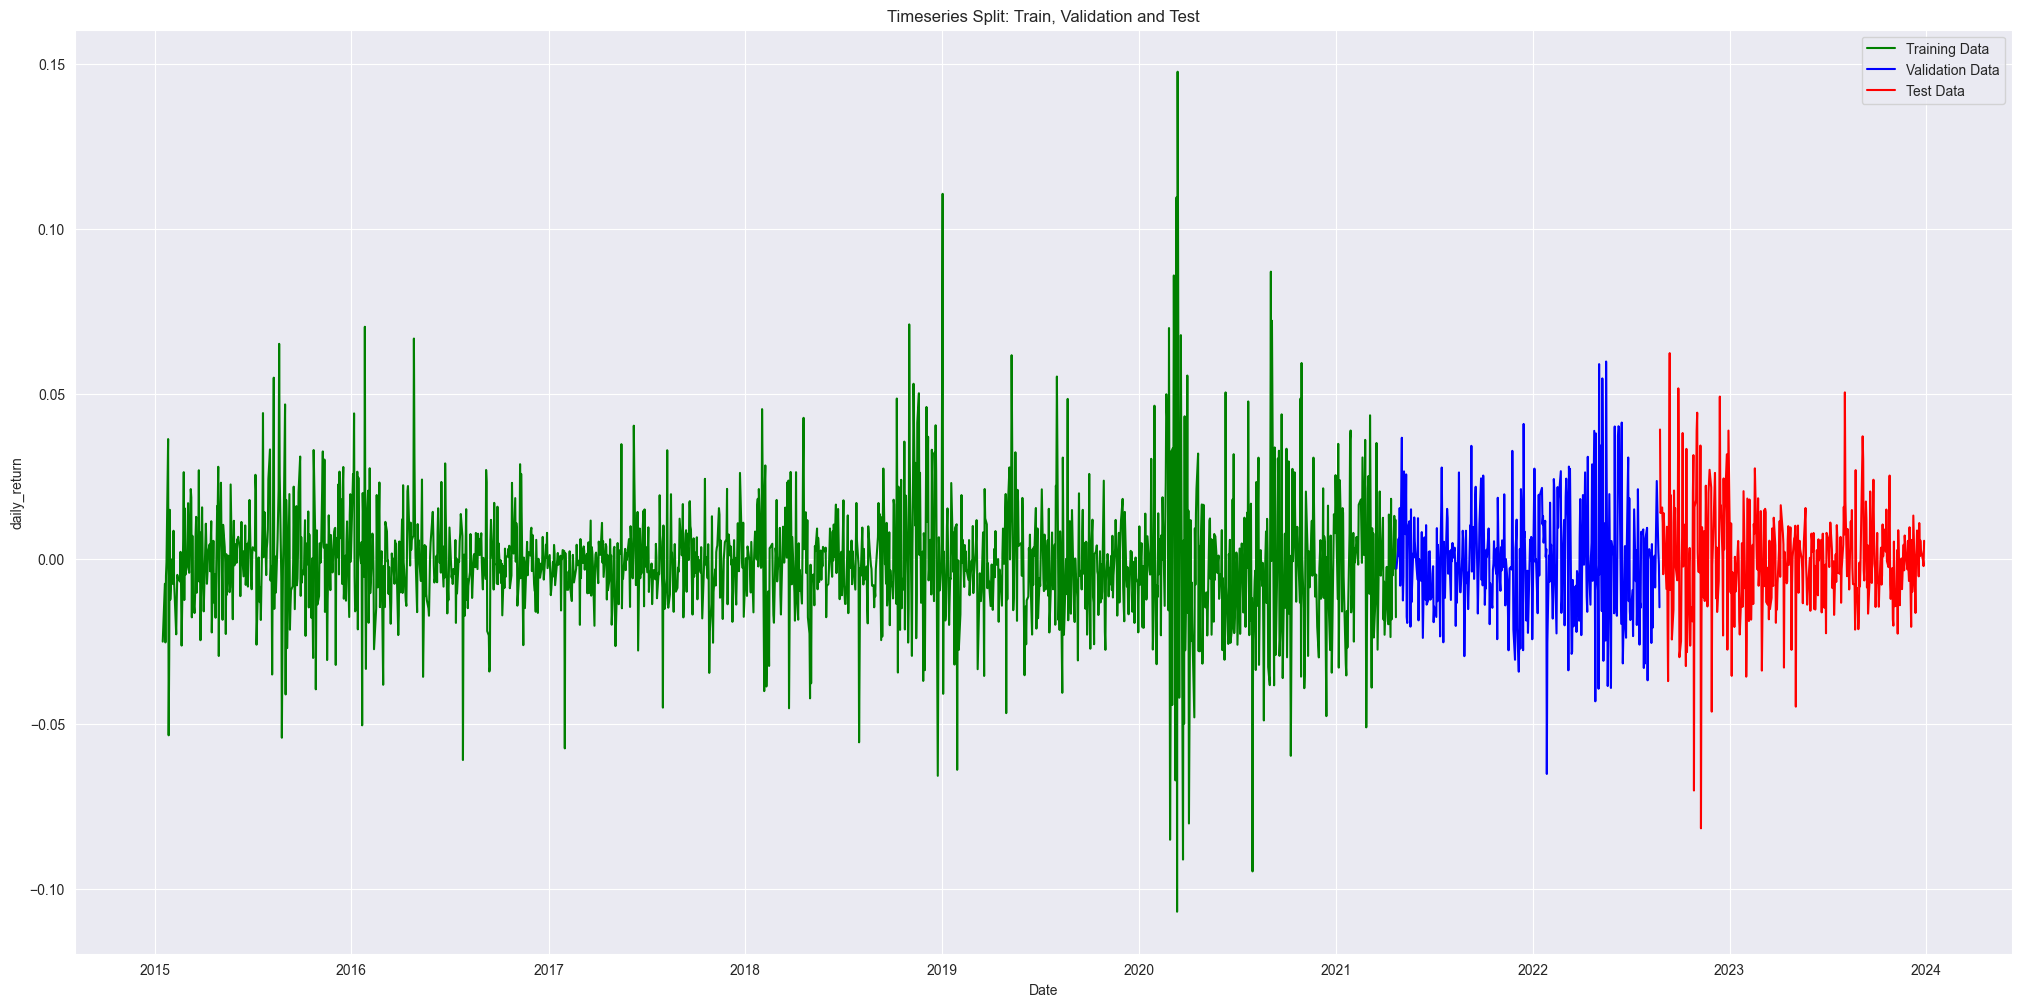

In [77]:
# Plot training data 
plt.figure(figsize=(25, 12))  # Change (width, height) as needed
plt.plot(train_data.index, train_data['daily_return'], label='Training Data', color='green')
# Plot validation data
plt.plot(val_data.index, val_data['daily_return'], label='Validation Data', color='blue')
# Plot test data
plt.plot(test_data.index, test_data['daily_return'], label='Test Data', color='red')
# Add labels, title, and legend
plt.xlabel('Date')  # Adjust based on your index
plt.ylabel('daily_return')  # Adjust based on your data column
plt.title('Timeseries Split: Train, Validation and Test')
plt.legend()
# Show the plot
plt.show()#SEEMS OK

# calculate the time diff between two adjacent events pos OR neg
## pos2pos 
## neg2neg
## pos2neg
## neg2pos

<Axes: xlabel='last_timestamp_pos'>

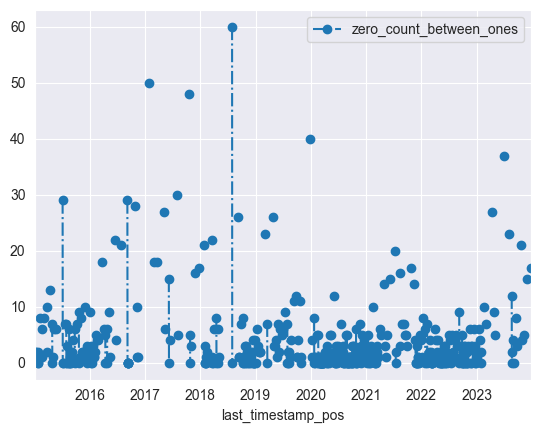

In [89]:
#overview of extreme events
df = final_input_data.copy()
df.reset_index(inplace=True)
# Create a 'segment' column to group zeros between ones
df['segment'] = (df['extreme_event'] == 1).cumsum()

# Count zeros in each segment, ignoring segments without zeros between ones
zero_counts = df[df['extreme_event'] == 0].groupby('segment').size()#.reset_index(name='zero_count_between_ones')
df['zero_count_between_ones'] = df['segment'].map(zero_counts).fillna(0).astype(int)

# Get the last timestamp of each segment (where 'IsExtreme' is 1)
df['last_timestamp_pos'] = df.groupby('segment')['date'].transform('last')

# Remove the helper 'segment' column if no longer needed
df = df.drop(columns='segment')


df[['last_timestamp_pos','zero_count_between_ones']].drop_duplicates().set_index('last_timestamp_pos').resample('D').asfreq().plot(marker='o',linestyle='-.')


<Axes: >

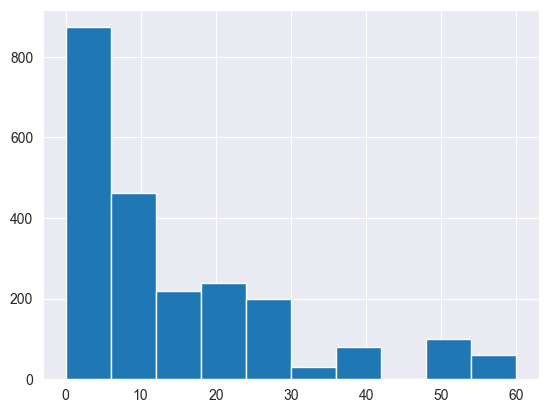

In [41]:
df['zero_count_between_ones'].hist()

In [23]:
#create extreme_pos and extreme_neg based on the sign of daily_returns
final_input_data['extreme_pos'] = np.where(np.sign(final_input_data['daily_return'])*final_input_data['extreme_event']==+1,1,0)
final_input_data['extreme_neg'] = np.where(np.sign(final_input_data['daily_return'])*final_input_data['extreme_event']==-1,1,0)

mean 14 days 08:47:08.571428571
std 23 days 06:57:31.074538836
mean_error 1 days 13:15:50.071635922


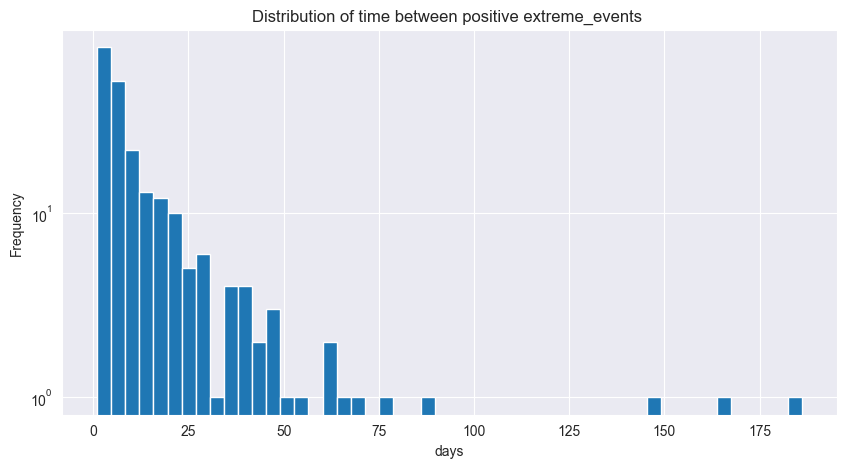

In [24]:
tmp = final_input_data[final_input_data['extreme_pos']==1].reset_index()[['date']]
tmp['date_diff'] = (tmp.date.shift(-1)-tmp.date)#.dt.total_seconds()
print("mean",tmp['date_diff'].mean())
print("std",tmp['date_diff'].std())
print("mean_error",tmp['date_diff'].std()/np.sqrt(tmp.shape[0]))
(tmp['date_diff'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5));
plt.title("Distribution of time between positive extreme_events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()

mean 14 days 03:26:36.521739130
std 16 days 23:00:14.286781535
mean_error 1 days 02:46:44.022346718


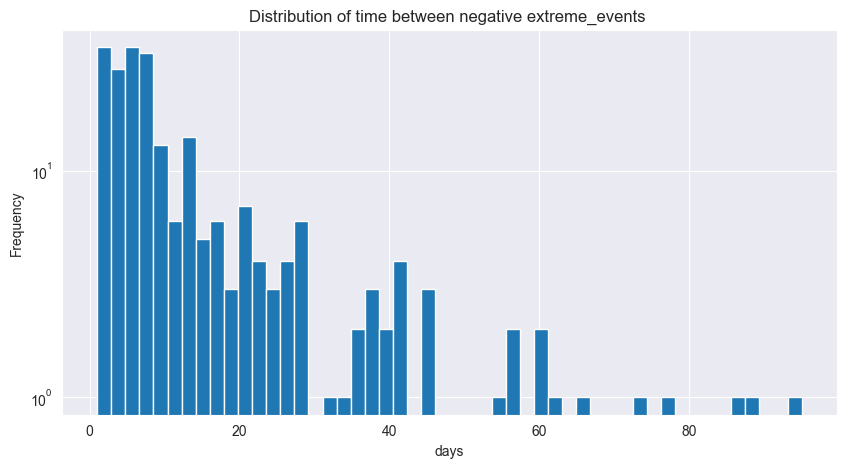

In [25]:
tmp = final_input_data[final_input_data['extreme_neg']==1].reset_index()[['date']]
tmp['date_diff'] = (tmp.date.shift(-1)-tmp.date)#.dt.total_seconds()
print("mean",tmp['date_diff'].mean())
print("std",tmp['date_diff'].std())
print("mean_error",tmp['date_diff'].std()/np.sqrt(tmp.shape[0]))
(tmp['date_diff'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5));
plt.title("Distribution of time between negative extreme_events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()

In [30]:
#A) keep only rows extreme_pos-> extreme_neg
df = final_input_data[final_input_data['extreme_event']==1][['extreme_pos','extreme_neg']]
# Ensure the data is sorted by Date to calculate time differences correctly
df.sort_index(inplace=True)
df.reset_index(inplace=True)
# Shift the Pos and Neg columns to compare consecutive rows
df['prev_pos']  = df['extreme_pos'].shift(1)
df['prev_date'] =df['date'].shift(1)
#Identify rows where `Pos` changes to `Neg` (Pos was True, Neg is now True)
pos_to_neg_mask = (df['prev_pos'] == True) & (df['extreme_neg'] == True)
# Calculate the time difference for rows matching the mask
df['time_diff_pos2neg'] = df['date'] - df['prev_date']
df['time_diff_pos2neg'] = df['time_diff_pos2neg'].where(pos_to_neg_mask)
print("mean",df['time_diff_pos2neg'].mean())
print("std",df['time_diff_pos2neg'].std())
print("mean_error",df['time_diff_pos2neg'].std()/np.sqrt(df.shape[0]))
df

mean 5 days 04:37:53.684210526
std 6 days 00:42:06.864408443
mean_error 0 days 06:46:34.635503834


,date,extreme_pos,extreme_neg,prev_pos,prev_date,time_diff_pos2neg
0,2015-01-02,1,0,NaN,NaT,NaT
1,2015-01-07,0,1,1.0,2015-01-02,5 days
2,2015-01-09,1,0,0.0,2015-01-07,NaT
3,2015-01-14,1,0,1.0,2015-01-09,NaT
4,2015-01-16,0,1,1.0,2015-01-14,2 days
...,...,...,...,...,...,...
451,2023-09-25,1,0,1.0,2023-09-19,NaT
452,2023-10-25,1,0,1.0,2023-09-25,NaT
453,2023-11-01,0,1,1.0,2023-10-25,7 days
454,2023-11-09,0,1,0.0,2023-11-01,NaT


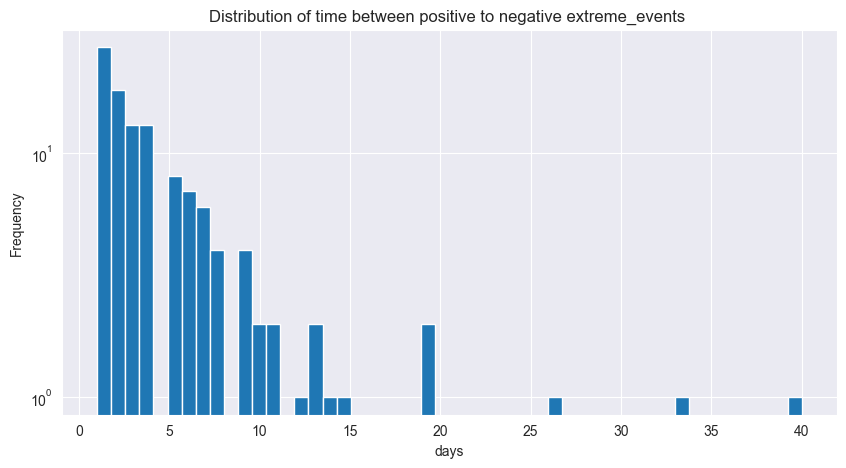

In [27]:
(df['time_diff_pos2neg'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5));
plt.title("Distribution of time between positive to negative extreme events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()

In [31]:
#B) keep only rows extreme_neg -> extreme_pos
df = final_input_data[final_input_data['extreme_event']==1][['extreme_pos','extreme_neg']]
# Ensure the data is sorted by Date to calculate time differences correctly
df.sort_index(inplace=True)
df.reset_index(inplace=True)
# Shift the Pos and Neg columns to compare consecutive rows
df['prev_neg']  = df['extreme_neg'].shift(1)
df['prev_date'] = df['date'].shift(1)
# Identify rows where `Neg` changes to `Pos` (Neg was True, Pos is now True)
neg_to_pos_mask = (df['prev_neg'] == True) & (df['extreme_pos'] == True)
# Calculate the time difference for rows matching the mask
df['time_diff_neg2pos'] = df['date'] - df['prev_date']
df['time_diff_neg2pos'] = df['time_diff_neg2pos'].where(neg_to_pos_mask)
print("mean",df['time_diff_neg2pos'].mean())
print("std",df['time_diff_neg2pos'].std())
print("mean_error",df['time_diff_neg2pos'].std()/np.sqrt(df.shape[0]))
df

mean 6 days 16:59:28.141592920
std 8 days 02:42:16.418843887
mean_error 0 days 09:07:04.355235503


,date,extreme_pos,extreme_neg,prev_neg,prev_date,time_diff_neg2pos
0,2015-01-02,1,0,NaN,NaT,NaT
1,2015-01-07,0,1,0.0,2015-01-02,NaT
2,2015-01-09,1,0,1.0,2015-01-07,2 days
3,2015-01-14,1,0,0.0,2015-01-09,NaT
4,2015-01-16,0,1,0.0,2015-01-14,NaT
...,...,...,...,...,...,...
451,2023-09-25,1,0,0.0,2023-09-19,NaT
452,2023-10-25,1,0,0.0,2023-09-25,NaT
453,2023-11-01,0,1,0.0,2023-10-25,NaT
454,2023-11-09,0,1,1.0,2023-11-01,NaT


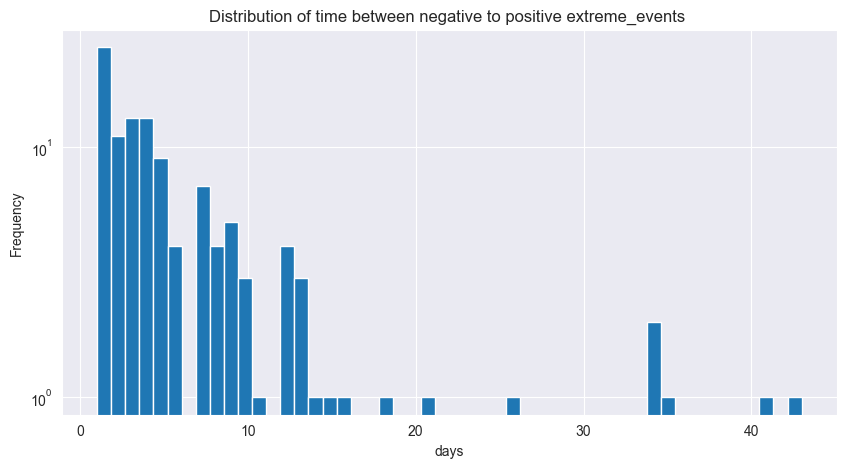

In [29]:
(df['time_diff_neg2pos'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5))
plt.title("Distribution of time between negative to positive extreme events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()